In [ ]:
# Importing the required packages here
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import fuzzywuzzy
from fuzzywuzzy import process 
import missingno 
from datetime import datetime, date
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import os
import statistics
import calplot
from sklearn.linear_model import LinearRegression
from scipy import stats
%matplotlib inline
# display all rows
# pd.set_option('max_columns', None)
# pd.set_option('max_rows', None)

# EXPLORATORY DATA ANALYSIS ON THE TRIPDATA DATASET

This is a capstone project for HyperionDev using python. The data is from Google Data Analytics Cyclistic Case study, and is a common dataset used in Kaggle for exploratory data analysis (EDA). 

## ASK

Business task: Design marketing strategies aimed at converting casual riders into annual members.

Exploratory questions:

- How do annual members and casual riders differ, 
- Why casual riders would buy a membership, 
- How digital media could affect their marketing tactics?

## PREPARE

The data is located: [tripdata] (https://divvy-tripdata.s3.amazonaws.com/index.html).  It was organised by csv files, separate one for each month. First entry date is 2021-07-01 and last entry 2022-06-30, the data includes 364 days of entries.

The company has their own license over the dataset. The dataset doesn't have any personal information about the riders. It is current, comprehensive, original and cited.

I uploaded the dataset (csv files) and combined into one single file. I applied strip() to handle any white spaces.

In [ ]:

# Get data file names
path = r'/Users/ashleycuzzocrea/Dropbox/AC22110004529/Data Science Bootcamp/T36/12months_cycle_dataset'
filenames = glob.glob(path + "/*tripdata.csv")

dfs = []
for filename in filenames:
    # print(filename.split('/')[-1])
    df = pd.read_csv(filename, index_col=None, header=0)
    df['file'] = filename.split('/')[-1]
    dfs.append(df)
    
# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)

# trim the string columns
for column in big_frame.columns:
    # print(column)
    if big_frame[column].dtype == 'object':
        big_frame[column] = big_frame[column].str.strip() 
big_frame.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,file
0,EC2DE40644C6B0F4,classic_bike,2022-05-23 23:06:58,2022-05-23 23:40:19,Wabash Ave & Grand Ave,TA1307000117,Halsted St & Roscoe St,TA1309000025,41.891466,-87.626761,41.943670,-87.648950,member,202205-divvy-tripdata.csv
1,1C31AD03897EE385,classic_bike,2022-05-11 08:53:28,2022-05-11 09:31:22,DuSable Lake Shore Dr & Monroe St,13300,Field Blvd & South Water St,15534,41.880958,-87.616743,41.886349,-87.617517,member,202205-divvy-tripdata.csv
2,1542FBEC830415CF,classic_bike,2022-05-26 18:36:28,2022-05-26 18:58:18,Clinton St & Madison St,TA1305000032,Wood St & Milwaukee Ave,13221,41.882242,-87.641066,41.907655,-87.672552,member,202205-divvy-tripdata.csv
3,6FF59852924528F8,classic_bike,2022-05-10 07:30:07,2022-05-10 07:38:49,Clinton St & Madison St,TA1305000032,Clark St & Randolph St,TA1305000030,41.882242,-87.641066,41.884576,-87.631890,member,202205-divvy-tripdata.csv
4,483C52CAAE12E3AC,classic_bike,2022-05-10 17:31:56,2022-05-10 17:36:57,Clinton St & Madison St,TA1305000032,Morgan St & Lake St,TA1306000015,41.882242,-87.641066,41.885779,-87.651025,member,202205-divvy-tripdata.csv


## PROCESS

The following section I will profile the downloaded data for data quality.

I summarised the data and dynamically checked for nulls and duplications to get a feel for what the data contains. I was particularly interested in ride_id, as it is the primary key. It returned 0 duplications.

### Count of non null values by feature

In [ ]:
# count values not including NaN
big_frame.count()

ride_id               5900385
rideable_type         5900385
started_at            5900385
ended_at              5900385
start_station_name    5064367
start_station_id      5064370
end_station_name      5008282
end_station_id        5008282
start_lat             5900385
start_lng             5900385
end_lat               5895011
end_lng               5895011
member_casual         5900385
file                  5900385
dtype: int64

### Number of unique values by feature

In [ ]:
# return number unique values
big_frame.nunique()

ride_id               5900385
rideable_type               3
started_at            4924385
ended_at              4924865
start_station_name       1293
start_station_id         1157
end_station_name         1315
end_station_id           1171
start_lat              493874
start_lng              471377
end_lat                371522
end_lng                342966
member_casual               2
file                       12
dtype: int64

### Percentage breakdown of null values

In [ ]:
# percentage null values 
null_percent = (
    big_frame
    .isnull().mean().mul(100).round(2)
    .to_frame(name = 'nan_percent')
    .query('nan_percent > 0')
)
print(null_percent)
# sum of duplicated ride_id
ride_id_dup = big_frame['ride_id'].duplicated().sum()
dups = big_frame.duplicated().sum()
print(f'There are {ride_id_dup} duplicated ride_id and {dups} duplicated observations')
# start_station_name and end_station_name nulls before update
SSN = big_frame['start_station_name'].isnull().sum()
ESN = big_frame['end_station_name'].isnull().sum()


                    nan_percent
start_station_name        14.17
start_station_id          14.17
end_station_name          15.12
end_station_id            15.12
end_lat                    0.09
end_lng                    0.09
There are 0 duplicated ride_id and 0 duplicated observations


In this section, I am going to investigate the nulls in the data set. From using filters I can see that there are null station names that have lat and lon data points.

I created a station name lookup data frame to use as part of a join back to the original rides dataset. If the start and end station was empty, a replacement from the lookup was substituted where available.

In [ ]:
# start station names
# drop duplicated rows
# df with only filtered columns
bf_notnull = (
    big_frame
    .head(6000000)
    .filter(items=['start_station_name', 'start_lat','start_lng'])
    .query('start_station_name.notnull()')
    .drop_duplicates()
    .copy()   
)
# # bf_notnull still contains duplicates because lat/lngs vary
# # addressing this by grouping by lat/lng
# # agg by cumcount and will drop observations greater than 0
bf_notnull['cumcount'] = (
    bf_notnull
    .groupby(['start_lat', 'start_lng'])
    .cumcount()
)
# # final step for bf_notnull
# # only keep first observations
# # drop cumcount col ready for join
bf_notnull = (
    bf_notnull
    .query('cumcount==0')
    .drop(['cumcount'],axis=1)
)
# left join the original df with filtered dataset 
big_frame = (
    big_frame
    .merge(bf_notnull, on=['start_lat','start_lng'],how ='left')
)

# # back fill by column 
big_frame['start_station_name_x'] = big_frame[['start_station_name_x', 'start_station_name_y']].bfill(axis=1).iloc[:, 0]
# # drop look-up column
big_frame.drop(['start_station_name_y'], axis=1, inplace=True)
# rename column to original name without _x
big_frame.rename(columns={'start_station_name_x':'start_station_name'}, inplace=True)

In [ ]:
# (
#     cleaned_df
#     .head(10000)
#     .filter(['start_station_name_x', 'start_station_name_y'])
#     # .query('start_station_name_x.isnull() and ~start_station_name_y.isnull()')
#     # .query('start_station_name_x.notnull() and start_station_name_y.isnull()')
#     .query('start_station_name_x != start_station_name_y')
# )

In [ ]:
# nulls before and after update 
SSN_after = big_frame['start_station_name'].isnull().sum()
print(f'start_station_name nulls before update: {SSN}')
print(f'start_station_name nulls after update: {SSN_after}')

start_station_name nulls before update: 836018
start_station_name nulls after update: 434242


In [ ]:
# end station names
# drop duplicated rows
# df with only filtered columns
df_notnull = (
    big_frame
    .head(6000000)
    .filter(items=['end_station_name', 'start_lat','start_lng'])
    .query('end_station_name.notnull()')
    .drop_duplicates()
    .copy()   
)
# df_notnull still contains duplicates because lat/lngs vary
# addressing this by grouping by lat/lng
# agg by cumcount and will drop observations greater than 0
df_notnull['cumcount'] = (
    df_notnull
    .groupby(['start_lat', 'start_lng'])
    .cumcount()
)
# final step for df_notnull
# only keep first observations
# drop cumcount col ready for join
df_notnull = (
    df_notnull
    .query('cumcount==0')
    .drop(['cumcount'],axis=1)
)
# left join the original df with filtered dataset 
big_frame = (
    big_frame
    .merge(df_notnull, on=['start_lat','start_lng'],how ='left')
)

# back fill by column 
big_frame['end_station_name_x'] = big_frame[['end_station_name_x', 'end_station_name_y']].bfill(axis=1).iloc[:, 0]
# drop look-up column
big_frame.drop(['end_station_name_y'], axis=1, inplace=True)
# # rename column to original name without _x
big_frame.rename(columns={'end_station_name_x':'end_station_name'}, inplace=True)


In [ ]:
# nulls before and after update 
ESN_after = big_frame['end_station_name'].isnull().sum()
print(f'end_station_name nulls before update: {ESN}')
print(f'end_station_name nulls after update: {ESN_after}')

end_station_name nulls before update: 892103
end_station_name nulls after update: 354800


There is an opportunity to use ML models to substitute more missing values however, it's not in scope of this EDA. Therefore, at this stage I am going to drop NaN when I aggregate on the feature that has NULLS, otherwise I want to leave as many observations in as possible.

### Summarise and Visualise Nulls After Replacement

                    nan_percent
start_station_name         7.36
start_station_id          14.17
end_station_name           6.01
end_station_id            15.12
end_lat                    0.09
end_lng                    0.09


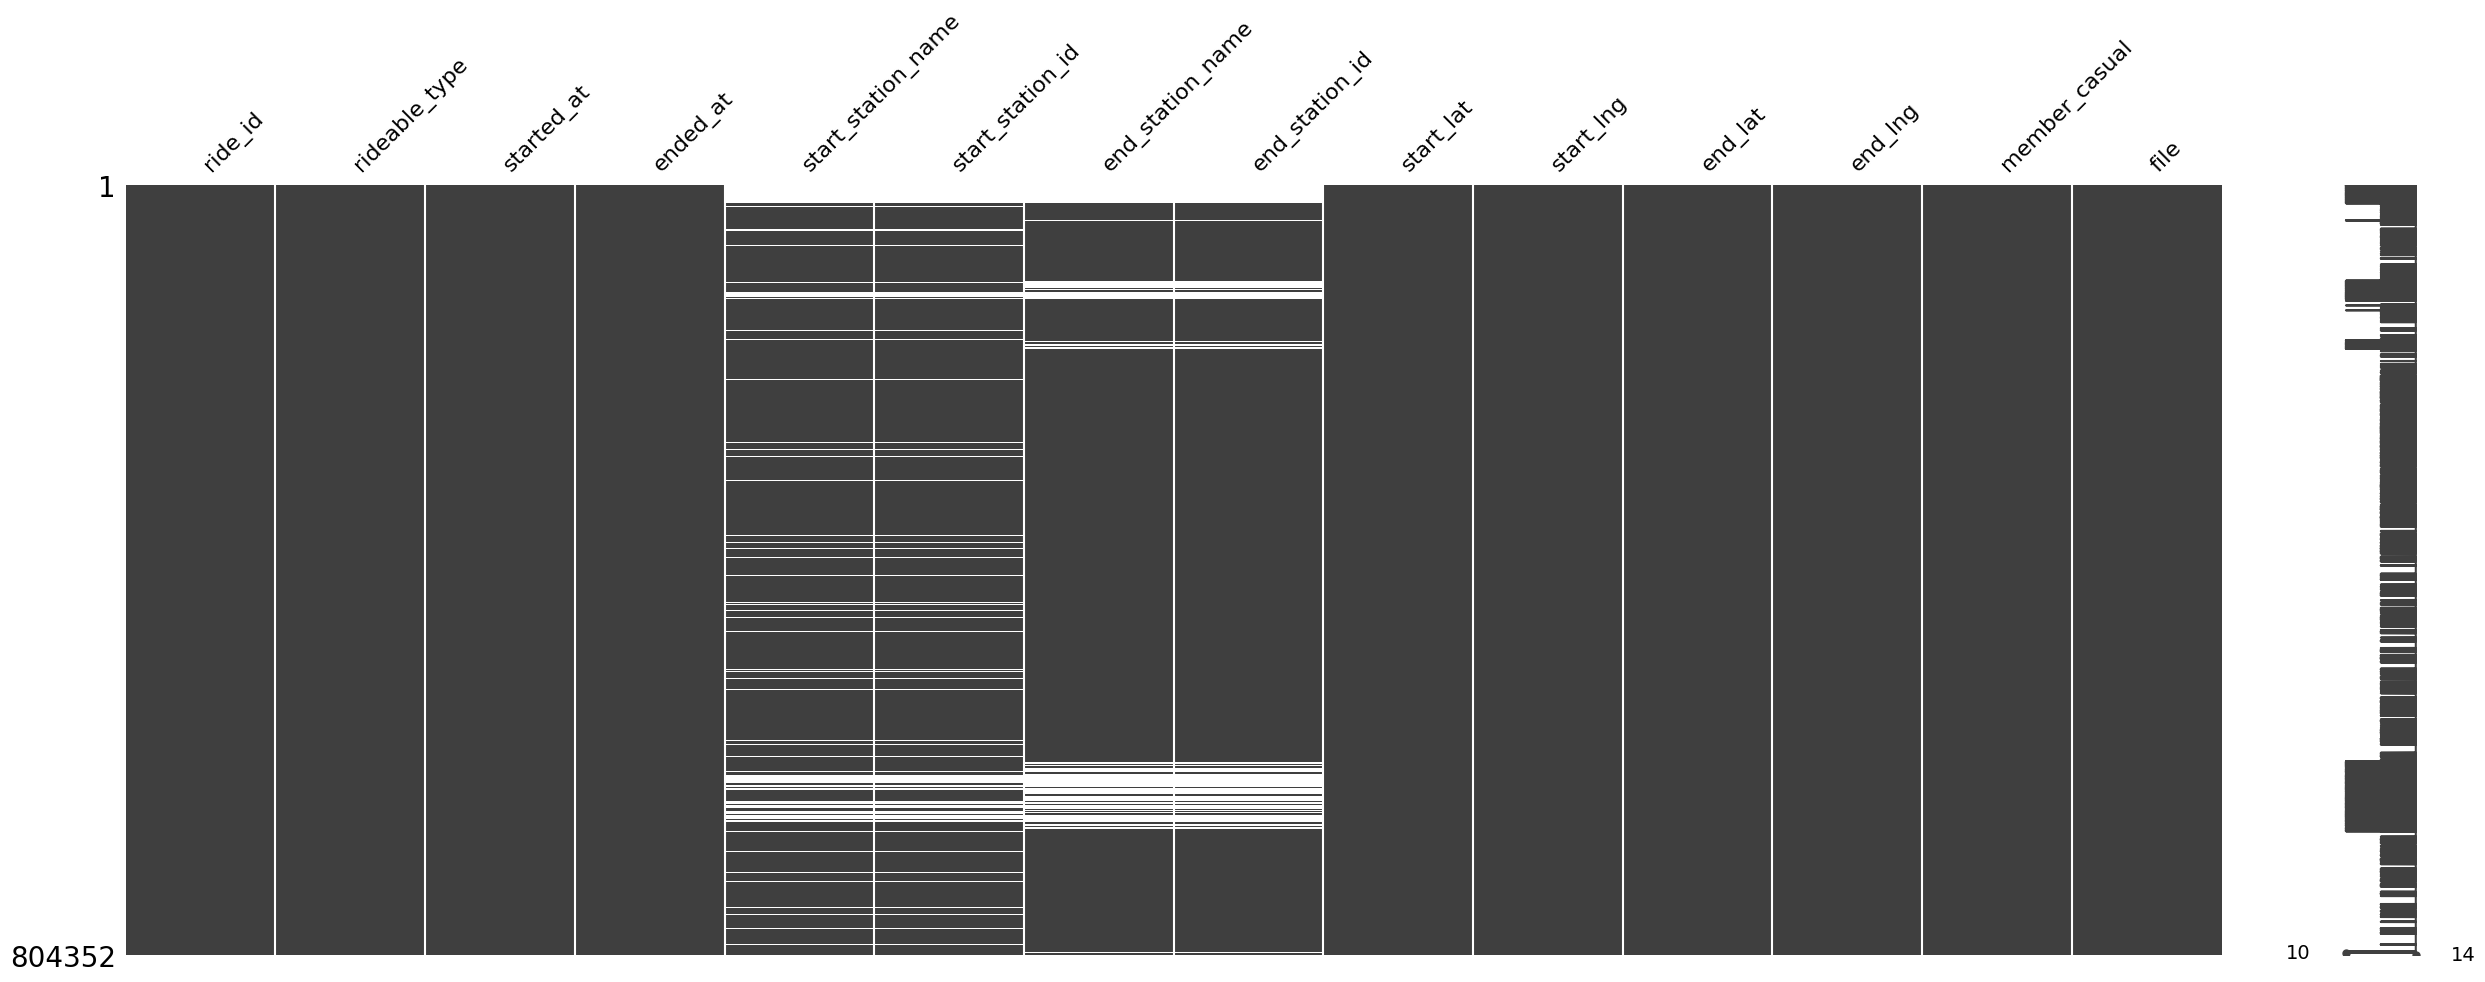

In [ ]:
# matrix show spread of NaN
missingno.matrix(df, figsize = (30,10))
print(big_frame
    .isnull().mean().mul(100).round(2)
    .to_frame(name = 'nan_percent')
    .query('nan_percent > 0'))

In [ ]:
# (
#     big_frame
#     .filter(['end_station_name', 'end_lat', 'end_lng'])
#     .query('end_lat.isnull() or end_lng.isnull()')
#     .query('end_station_name.isnull()')
#     # .query('start_station_name_x.notnull() and start_station_name_y.isnull()')
#     # .query('start_station_name_x != start_station_name_y')
# )

Next I checked to make sure entries for member_casual are correct based on my expected values as this will be a key field for my analysis phase. As expected there was two rider types 'casual' and 'member'.

In [ ]:
expected = ['casual','member']
# check expected values against actual
actual = (
    big_frame
    .filter(['member_casual'])
    .isin(expected)
)

if False in actual:
    print("Error found in data, following unexpected rider types found")
else:
    print("Rider types are checked to only contain the following:", expected)



Rider types are checked to only contain the following: ['casual', 'member']


I wanted to check that station ID and station name matched. There are duplicate station ID's for station name, and there are station names that share the same ID. It looks like the station names that share an ID are the same location where the wording of the name is slightly different. It is something to be aware of in my analysis, and in the real world I would consider checking with the sender if possible to rule out extract errors. In this instance, I have decided not to try to clean the data as it doesn't directly impact my overall analysis when aggregating on member and casual ride counts. Additionally, ride id can be use as unique key. 

### Start stations that do not have unique not null station ids

In [ ]:
# df with unique observations filtered by name and id
df_station_id = (
    big_frame
    .filter(["start_station_name","start_station_id"])
    .drop_duplicates(inplace=False)
    .copy()
)

In [ ]:
# checking for duplicates on station name
print((
    df_station_id
    .query('start_station_id.notnull()')
    .groupby(["start_station_name"])
    .size()
    .reset_index(name='count')
    .query('count>1')
))

# checking for duplicates on station id
# Start stations that share unique not null station ids:
# print((
#     df_station_id
#     .query('start_station_id.notnull()')
#     .groupby(["start_station_id"])
#     .size()
#     .reset_index(name='count')
#     .query('count>1')
# ))

                   start_station_name  count
99                       Bradley Park      2
130        California Ave & Cortez St      2
151             Calumet Ave & 51st St      2
152             Calumet Ave & 71st St      2
186      Central Park Ave & Ogden Ave      2
204     Christiana Ave & Lawrence Ave      2
343            East End Ave & 87th St      2
350           Eggleston Ave & 92nd St      2
423             Halsted St & 111th St      2
496            Jeffery Blvd & 67th St      2
600           Lake Park Ave & 47th St      2
609   Lakefront Trail & Bryn Mawr Ave      2
637           Lawndale Ave & 111th St      2
679               Loomis St & 89th St      2
862       Prairie Ave & Garfield Blvd      2
1183                  WEST CHI-WATSON      2
1186             Wabash Ave & 87th St      2


I checked for test rides that were made by the company and removed them from the dataset. Removed the following:

In [ ]:
# search for test in station name
(
    big_frame
    # .head(6000000)
    .filter(['start_station_name'])
    .dropna()
    .query("start_station_name.str.upper().str.contains('TEST')")
   
)
# big_frame.drop(index=?,inplace=True)


,start_station_name
4001549,Pawel Bialowas - Test- PBSC charging station


In [ ]:
# above query returned index 4001549 with Test in station name
# next I remove this observation with drop
big_frame.drop(index=4001549,inplace=True)

I have added columns that list the date, month, day, and year of each ride. This will allow me to aggregate ride data for each month, day, or year. I also included a "ride_length" calculation to big_frame (in mins).

Additionally, It was explained that some bikes were taken out of docks and checked for quality by Divvy. I checked using a filter to see if these had been included as entries in the data. 

- There were 146 rows where ride_length was negative which I have removed. 
- I have dropped ride length that are less than 5 seconds.

In [ ]:
# convert object to datetime
big_frame['started_at'] = pd.to_datetime(big_frame['started_at'], format='%Y-%m-%d %H:%M:%S')
big_frame['ended_at'] = pd.to_datetime(big_frame['ended_at'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# split datetime into separate columns for analysis 
big_frame['month'] = big_frame['started_at'].dt.month
big_frame['day'] = big_frame['started_at'].dt.day
big_frame['year'] = big_frame['started_at'].dt.year 
big_frame['day_of_week'] = big_frame['started_at'].dt.day_name()
## big_frame['day_of_week'] = big_frame['started_at'].dt.strftime('%A') 
big_frame['start_hour'] = big_frame['started_at'].dt.hour
big_frame['ride_length'] = round((big_frame['ended_at'] - big_frame['started_at']).dt.total_seconds() / 60.0, 2)

# distance is an approximation 
# np.sqrt returns the non-negative square-root of an array, element-wise.
# python distance of coordinates
# dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

big_frame['ride_km'] = np.sqrt( ((big_frame['end_lat'] - big_frame['start_lat'])**2) + ((big_frame['end_lng'] - big_frame['start_lng'])**2) )
  
 # Multiply the degrees of separation of longitude and latitude by 111.139 to get the corresponding linear distances in meters.
big_frame['ride_km'] = round(big_frame['ride_km'] * 111.139, 2)

big_frame['rider_speed'] = round(big_frame['ride_km']/(big_frame['ride_length'] * 60), 2)
# big_frame['started_at'].max() - big_frame['started_at'].min() 


In [ ]:
# drop rows where ride length is less than 5 seconds
(
    big_frame
    .drop(big_frame[(big_frame['ride_length'] <=0.05)].index, inplace=True)
)

## ANALYSIS



A summary of my analysis: casual vs member

There are 10 percent more member riders then there is casual riders. 

In [ ]:
# member casual count and percent
(
      big_frame
    .groupby("member_casual")
    .size()
    # .to_frame('ct')
    .reset_index(name='count')
    .eval('percent = count/count.sum()*100').round()
)

# (
#     big_frame
#     .groupby("member_casual")
#     .size()
#     # .to_frame('ct')
#     .reset_index(name='count')
#     .assign(n = lambda df: round((df['count']/df['count'].sum()*100),0))
# )


,member_casual,count,percent
0,casual,2555082,43.0
1,member,3335683,57.0


I did a grouping on rideable type to look at the distribution across the different bike types.

In [ ]:
# percent by rideable type
(
    big_frame
    .filter(['member_casual', 'rideable_type'])
    .value_counts(normalize=True).mul(100).round(0)
    .reset_index(name='percentage')
)

# (
#     big_frame
#     .groupby(['member_casual', 'rideable_type'])
#     .size()
#     .to_frame('count')
#     .assign(n = lambda df: round((df['count']/df['count'].sum()*100),0))
# )

,member_casual,rideable_type,percentage
0,member,classic_bike,33.0
1,member,electric_bike,23.0
2,casual,classic_bike,21.0
3,casual,electric_bike,18.0
4,casual,docked_bike,4.0


A table to show aggregated data on ride length of a member and casual bike ride.

In [ ]:
# descriptive statistics
(
    big_frame
    .filter(['member_casual','ride_length'])
    .groupby('member_casual')['ride_length']
    .agg(['mean', 'median', 'min', 'max'])
    .round(2)
    .reset_index()
)

,member_casual,mean,median,min,max
0,casual,29.86,14.87,0.07,49107.15
1,member,13.01,9.08,0.07,1559.90


A table to show mean ride length, number of rides and percentage rides between member and casual on day of week.

In [ ]:
# ordering days of the week
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
big_frame['day_of_week'] = pd.Categorical(big_frame['day_of_week'], categories=cats, ordered=True)
# big_frame = big_frame.sort_values('day_of_week')

(
    big_frame
    .groupby(['member_casual', 'day_of_week'])['ride_length']
    .agg(mean_ride_length = 'mean', num_rides = 'count').round(2)
    .assign(percent_rides = lambda df: round((df['num_rides']/df['num_rides'].sum()*100),2))
    .reset_index()
)

,member_casual,day_of_week,mean_ride_length,num_rides,percent_rides
0,casual,Monday,30.66,303629,5.15
1,casual,Tuesday,25.78,277433,4.71
2,casual,Wednesday,25.77,285119,4.84
3,casual,Thursday,27.26,324781,5.51
4,casual,Friday,28.30,362682,6.16
5,casual,Saturday,32.28,534905,9.08
6,casual,Sunday,34.50,466533,7.92
7,member,Monday,12.66,468162,7.95
8,member,Tuesday,12.21,517328,8.78
9,member,Wednesday,12.23,515515,8.75


A table to show the number of rides between casual and members by the time of day and the day of week.

In [ ]:
# A table to show the number of rides between casual and members by the time of day and the day of week.
(
    big_frame
    .groupby(['day_of_week', 'start_hour', 'member_casual'])
    .size()
    .reset_index(name='ride_count')
    .head()
)

,day_of_week,start_hour,member_casual,ride_count
0,Monday,0,casual,5172
1,Monday,0,member,3071
2,Monday,1,casual,3072
3,Monday,1,member,1806
4,Monday,2,casual,2121


A table to show percentage rides by month and percentage difference between member and casual.

In [ ]:
# pct = percentage
(
    big_frame
    .groupby(['month', 'member_casual']).size().to_frame('ride_count').reset_index()
    .eval('pct=ride_count/ride_count.sum() * 100')
    .pivot(index='month',columns='member_casual',values='pct').reset_index().round(2)
    .eval('pct_difference = member - casual')
    .eval('pct_total = member + casual')
)

member_casual,month,casual,member,pct_difference,pct_total
0,1,0.31,1.44,1.13,1.75
1,2,0.36,1.59,1.23,1.95
2,3,1.52,3.29,1.77,4.81
3,4,2.14,4.14,2.00,6.28
4,5,4.75,6.00,1.25,10.75
5,6,6.26,6.78,0.52,13.04
6,7,7.50,6.45,-1.05,13.95
7,8,7.00,6.64,-0.36,13.64
8,9,6.17,6.65,0.48,12.82
9,10,4.36,6.34,1.98,10.70


## SHARE

Supporting visualizations

A bar chart to show number of rides by day and membership. We can see that fewer casual riders make trips on week days and the inverse is true on the weekend.

[Text(0.5, 1.0, 'Number of Rides Per Day')]

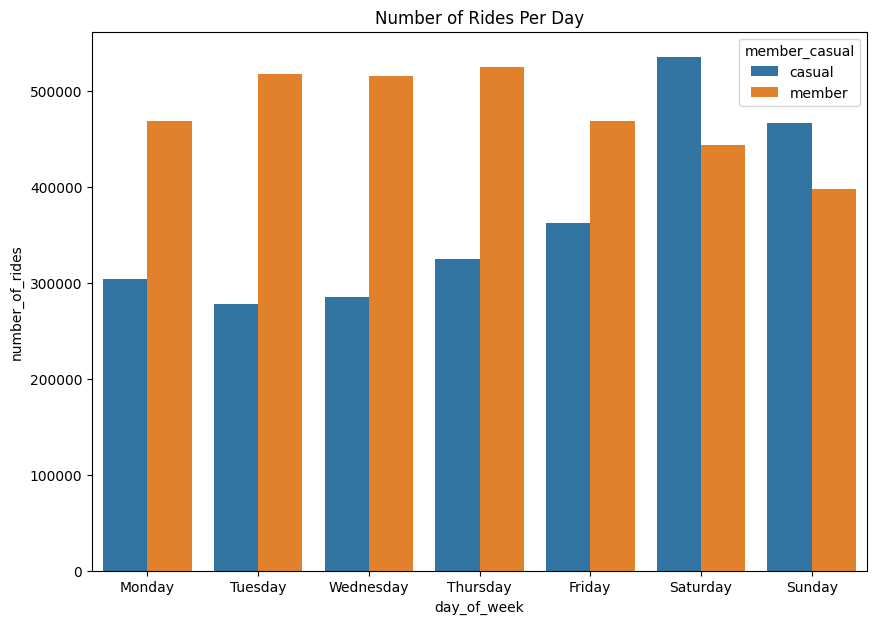

In [ ]:
# barplot num rides per day
fig, ax = plt.subplots(figsize=(10, 7))
(
    big_frame
    .groupby(['member_casual', 'day_of_week'])
    .size().reset_index(name='number_of_rides')
    .pipe((sns.barplot, 'data'), hue='member_casual', y='number_of_rides', x='day_of_week',ax=ax)
    .set(title='Number of Rides Per Day')
)

A bar chart to show average ride length on different days of the week between casual and members. We can see that on average, trip duration is considerably longer amongst casual riders.

[Text(0.5, 1.0, 'Average Ride Length by Day')]

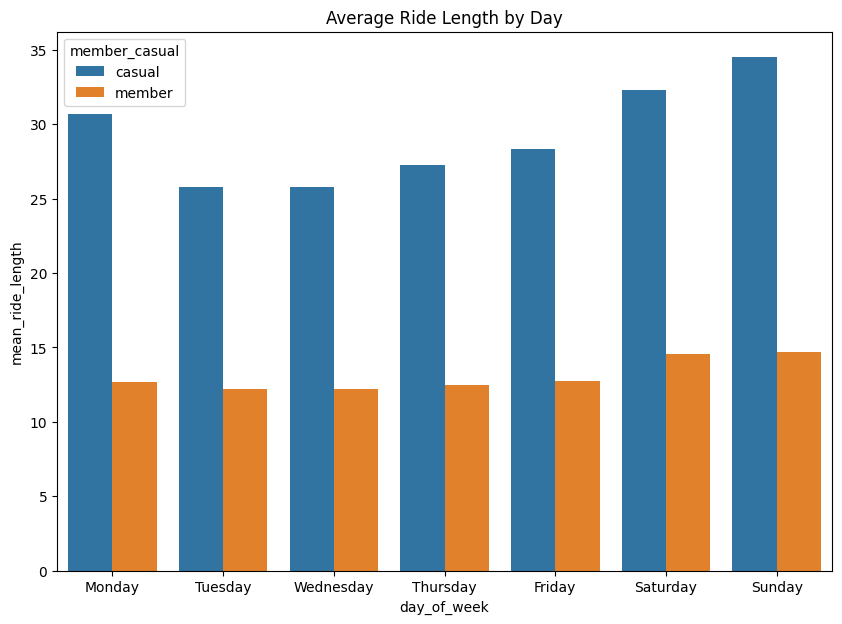

In [ ]:

# barplot mean ride length per day
fig, ax = plt.subplots(figsize=(10, 7))

(
    big_frame
    .groupby(['member_casual', 'day_of_week'])['ride_length']
    .agg('mean').round(2)
    .reset_index(name='mean_ride_length')
    .pipe((sns.barplot, 'data'), hue='member_casual', y='mean_ride_length', x='day_of_week',ax=ax)
    .set(title='Average Ride Length by Day')
)

The plot below shows the mean distance by member causal. We can see that members and casual riders are making similar length journeys.We can infer from this that member ride much faster than casual riders.

[Text(0.5, 1.0, 'Average Ride Distance by Day')]

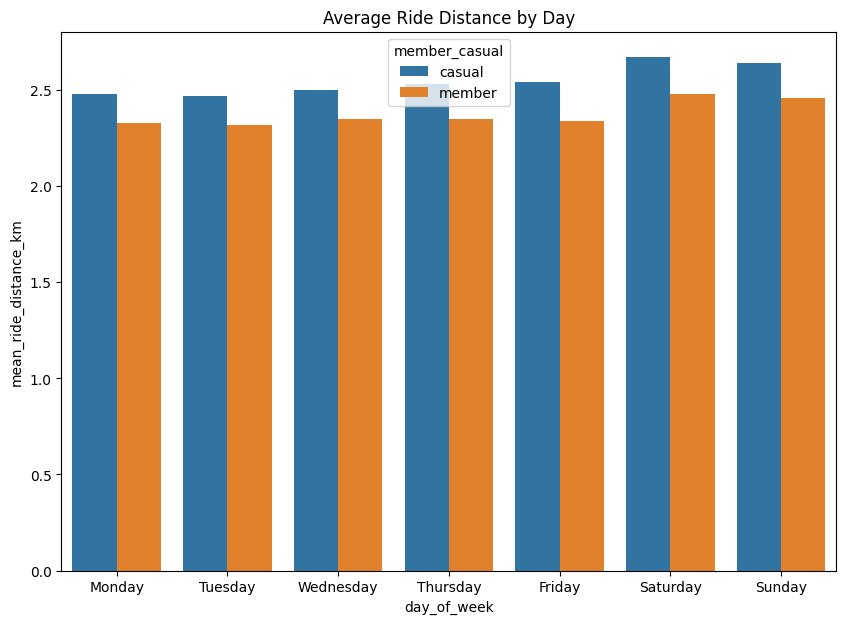

In [ ]:
# mean ride distance KM by day and member_casual
fig, ax = plt.subplots(figsize=(10, 7))

(
    big_frame
    .groupby(['member_casual', 'day_of_week'])['ride_km']
    .agg('mean').round(2)
    .reset_index(name='mean_ride_distance_km')
    .pipe((sns.barplot, 'data'), hue='member_casual', y='mean_ride_distance_km', x='day_of_week',ax=ax)
    .set(title='Average Ride Distance by Day')
)

A graph to show the number of rides between casual and members by the time of day and the day of week. Split by day of week. I observed that week day and weekend follows a consistent pattern with member usage spikes at weekday rush hours.

In [ ]:
# create df for facetGrid
ride_by_hour_day = (
    big_frame
    .groupby(['day_of_week', 'start_hour', 'member_casual'])
    .size()
    .reset_index(name='ride_count')
    .copy()
)

In [ ]:
# validate data against graph
# (
#     ride_by_hour_day
#     .groupby(['day_of_week','member_casual', 'start_hour'])['ride_count']
#     .sum()
#     .to_frame()
#     .query("member_casual == 'member'")
#     .head()
# )

Text(0.5, 0.98, 'Member, Casual Ride Count by Hour and Day')

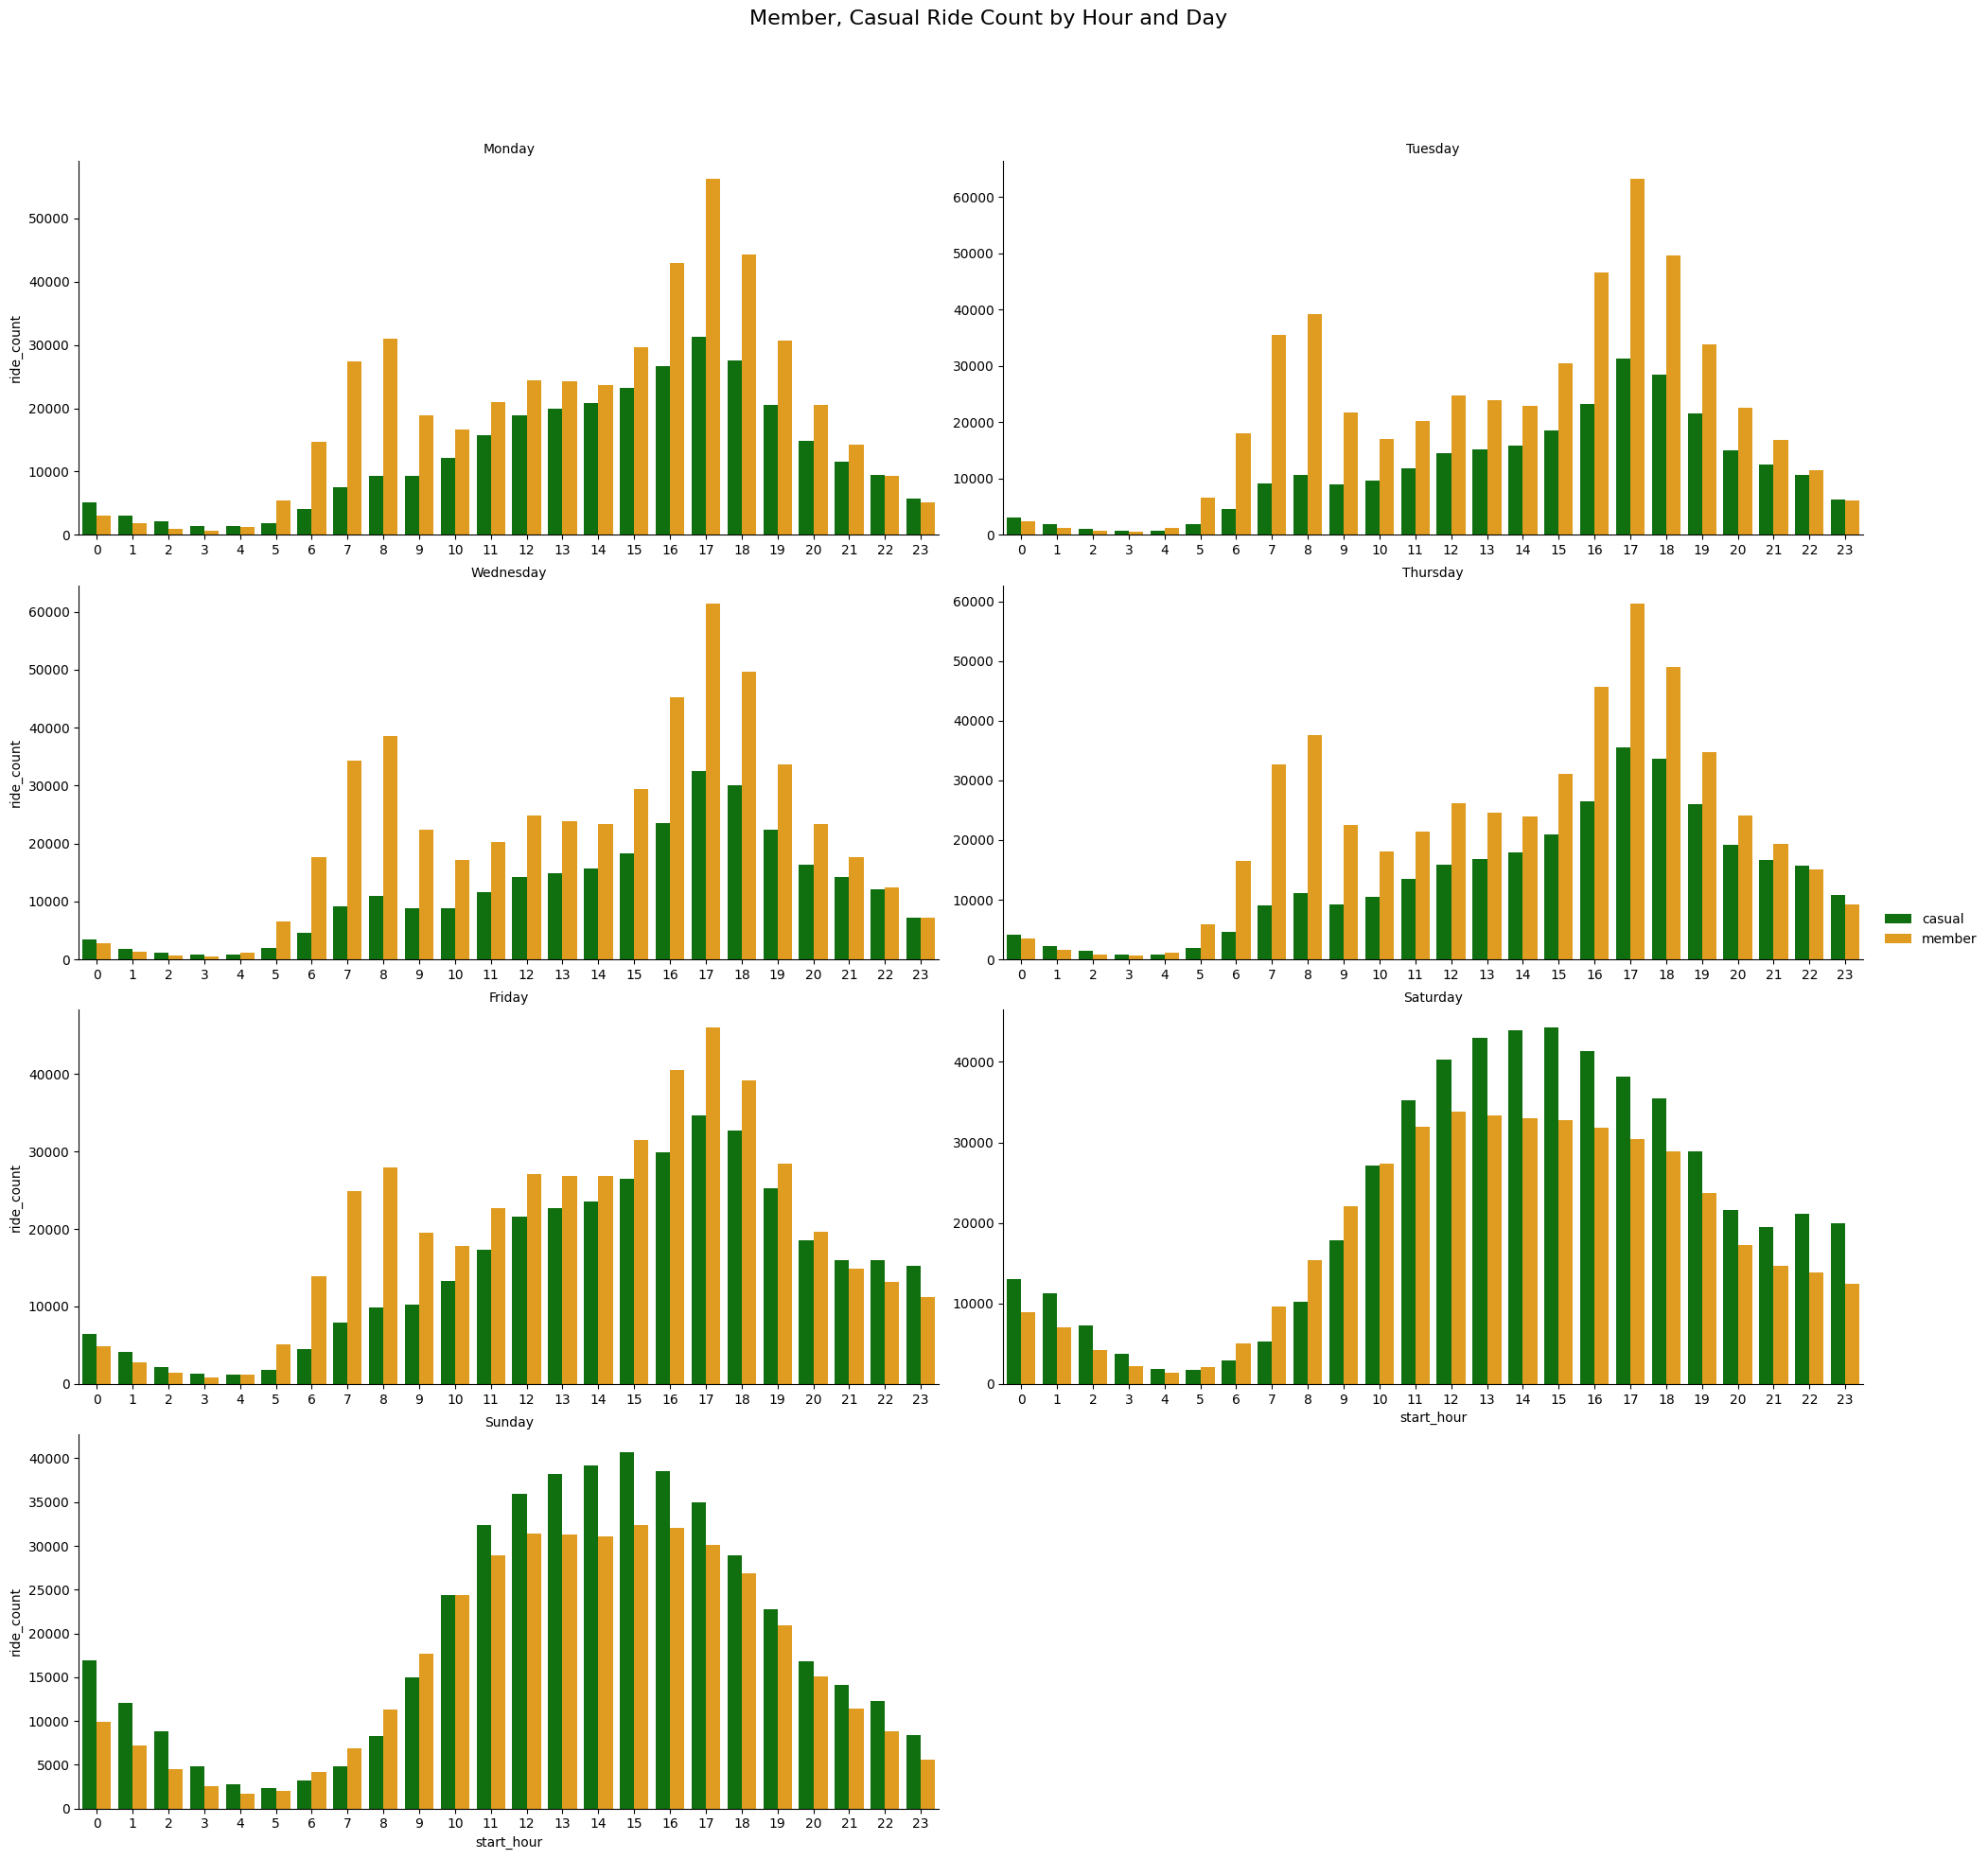

In [ ]:
# facetgrid to map df to multiple barplots split by day of week
fg = sns.FacetGrid(data=ride_by_hour_day, col='day_of_week', col_wrap=2, aspect = 2, height = 5, sharex=False, sharey=False)
fg.map_dataframe(func=sns.barplot, x="start_hour", y="ride_count", hue='member_casual', palette=['green', 'orange'], dodge=True)
fg.add_legend()
fg.set_titles("{col_name}")
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('Member, Casual Ride Count by Hour and Day', fontsize=16)

A line graph to show the number of rides between casual and members by the time of day and the day of week. Split by member and casual.

Text(0.5, 0.98, 'Member, Casual Ride Count by Hour and Day')

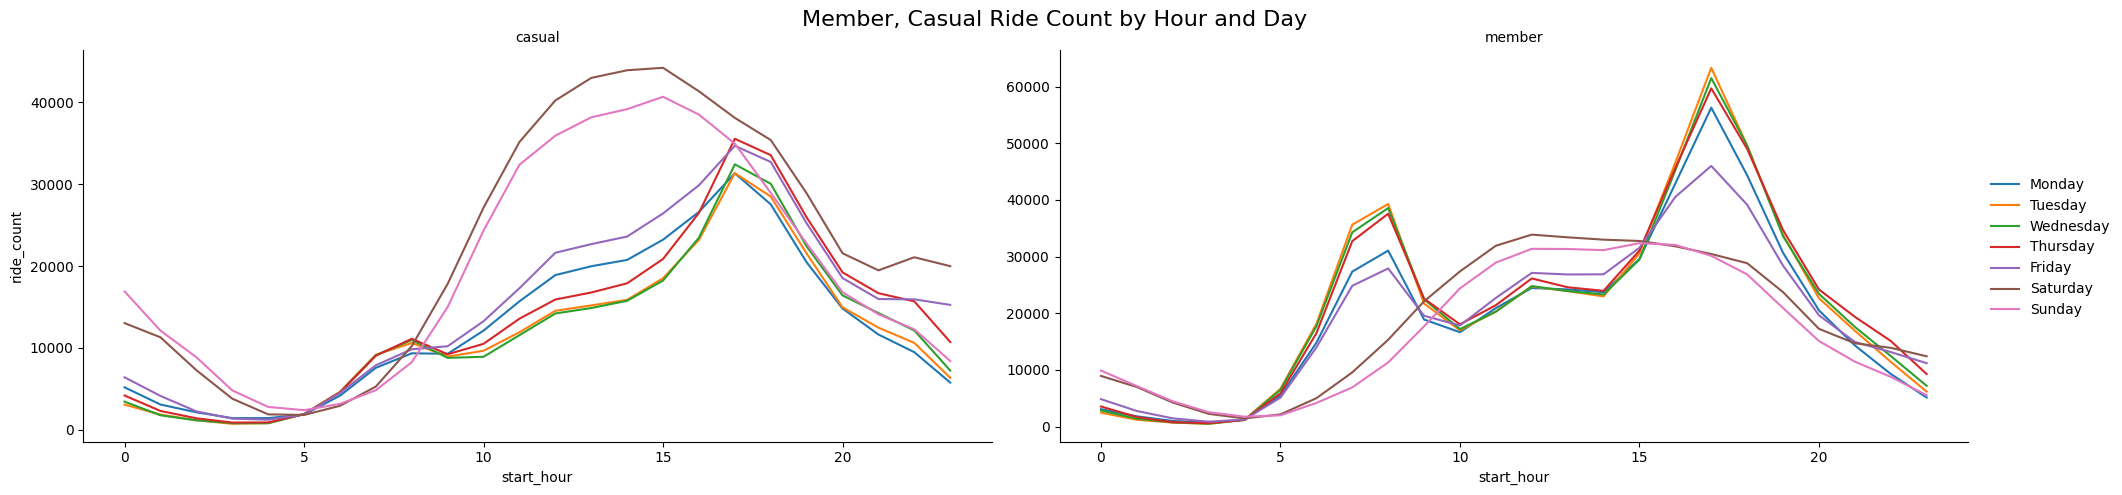

In [ ]:
# facetgrid split by member casual
fg = sns.FacetGrid(data=ride_by_hour_day, col='member_casual', col_wrap=2, aspect = 2, height = 5, sharex=False, sharey=False)
fg.map_dataframe(func=sns.lineplot, x="start_hour", y="ride_count", hue='day_of_week')
fg.add_legend()
fg.set_titles("{col_name}")
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('Member, Casual Ride Count by Hour and Day', fontsize=16)
# plt.tight_layout()

A graph and calender visualization below summarises number of rides by months. You can see that, as expected, spring and summer are the most popular months. Also, members are more likely to continue riding through autumn.

<Axes: xlabel='month', ylabel='count'>

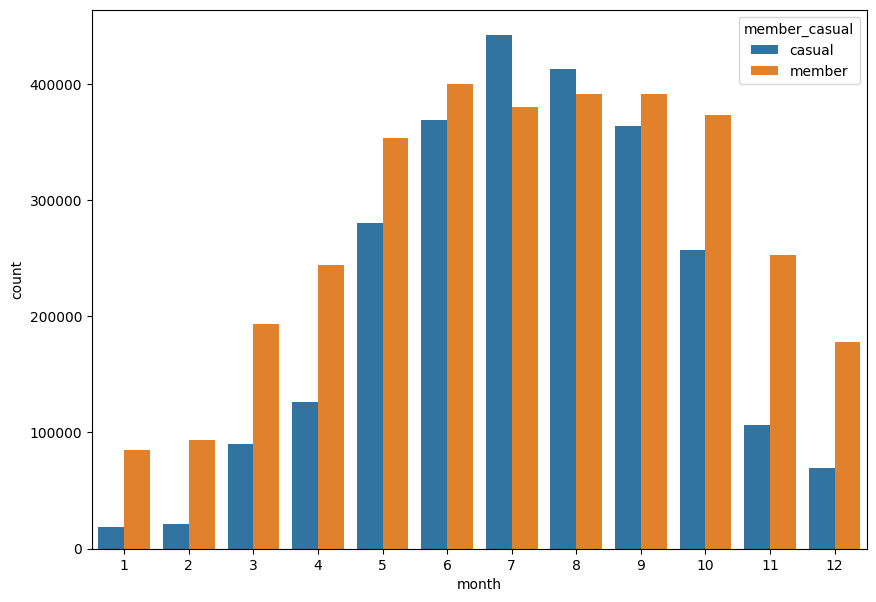

In [ ]:
# barplot ride by month
fig, ax = plt.subplots(figsize=(10, 7))
(
    big_frame
    .groupby(['member_casual', 'month'])
    .size()
    .reset_index(name='count')
    .pipe((sns.barplot, 'data'), hue='member_casual', x='month',y='count', ax=ax,dodge =True)
    # .pipe(lambda _df: sns.countplot(data= _df, y='month', hue='member_casual'))
)


(<Figure size 1250x340 with 3 Axes>,
 array([<Axes: ylabel='2021'>, <Axes: ylabel='2022'>], dtype=object))

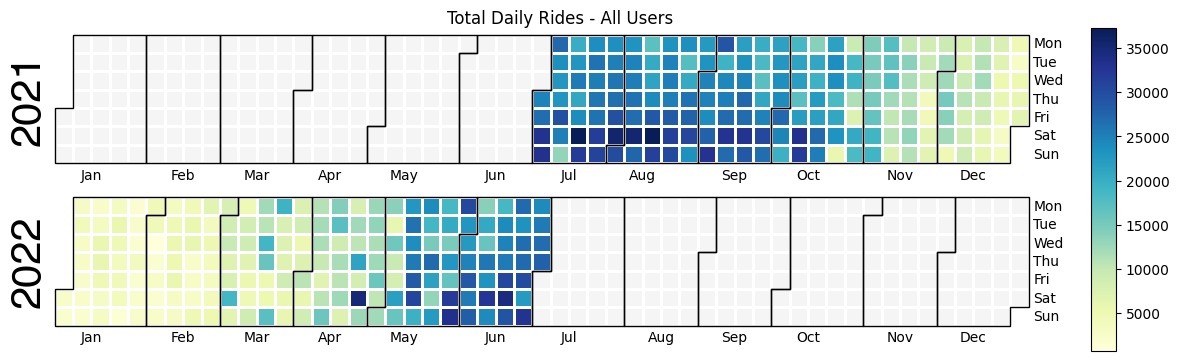

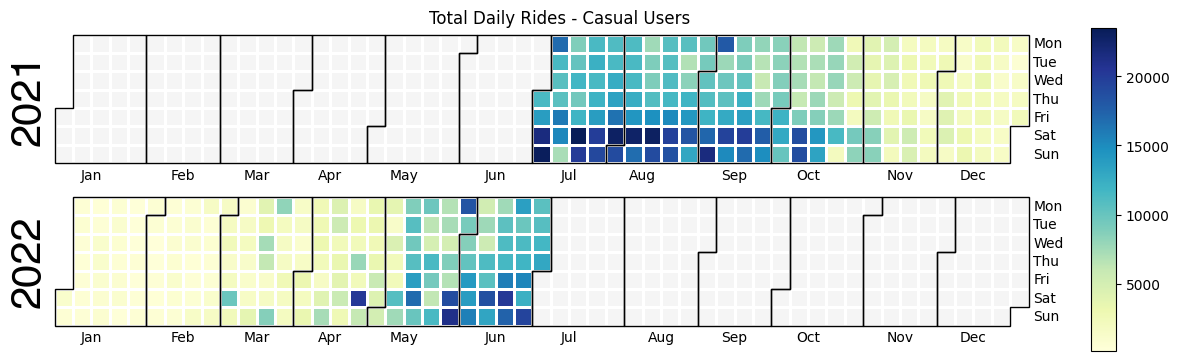

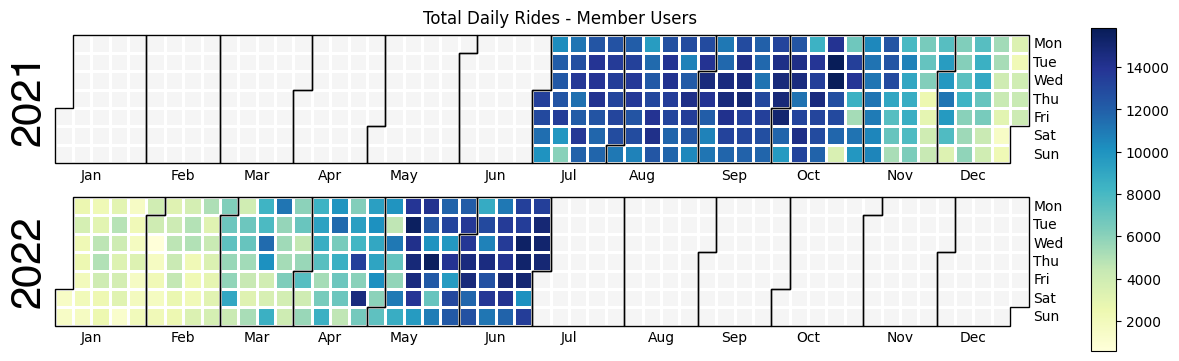

In [ ]:
#dataframe for time based analysis
timedf = big_frame.loc[:,['started_at', 'ended_at', 'member_casual','month', 'day', 'year', 'day_of_week','start_hour', 'ride_length']].copy()
timedf.insert(9,'numrides',1)

# converting member_causal to boolean
timedf.rename(columns = {'member_casual': 'is_member'}, inplace=True)
timedf.replace({'is_member': {'member': True, 'casual': False}}, inplace=True)

# date-time is converted to midnight i.e. 00:00:00 as not using time
timedf['date'] = timedf['started_at'].dt.normalize()

#df for calplot for all users
cal1 = timedf[['numrides','date']]
cal1.set_index('date', inplace = True)
cal1 = cal1.groupby('date').count()

# #df for calplot for casuals
casuals = timedf[timedf['is_member']==False].copy()
casuals['date'] = casuals['started_at'].dt.normalize()
cal2 = casuals[['numrides','date']]
cal2.set_index('date', inplace = True)
cal2 = cal2.groupby('date').sum()

# #df for calplot for members
members = timedf[timedf['is_member']==True].copy()
members['date'] = members['started_at'].dt.normalize()
cal3 = members[['numrides','date']]
cal3.set_index('date', inplace = True)
cal3 = cal3.groupby('date').sum()

#calplot for all users
calplot.calplot(cal1['numrides'],               
                yearlabel_kws={'color': 'black'},
                colorbar=True, 
                linewidth=1,
                edgecolor="Black",                
                suptitle= 'Total Daily Rides - All Users', cmap = 'YlGnBu')

#calplot for casuals
calplot.calplot(cal2['numrides'],               
                yearlabel_kws={'color': 'black'},
                colorbar=True, 
                linewidth=1,
                edgecolor="Black",                
                suptitle= 'Total Daily Rides - Casual Users', cmap = 'YlGnBu')

#calplot for members
calplot.calplot(cal3['numrides'],               
                yearlabel_kws={'color': 'black'},
                colorbar=True, 
                linewidth=1,
                edgecolor="Black",                
                suptitle= 'Total Daily Rides - Member Users', cmap = 'YlGnBu')

The plots below show the number of ride by season

(0.0, 25000.0)

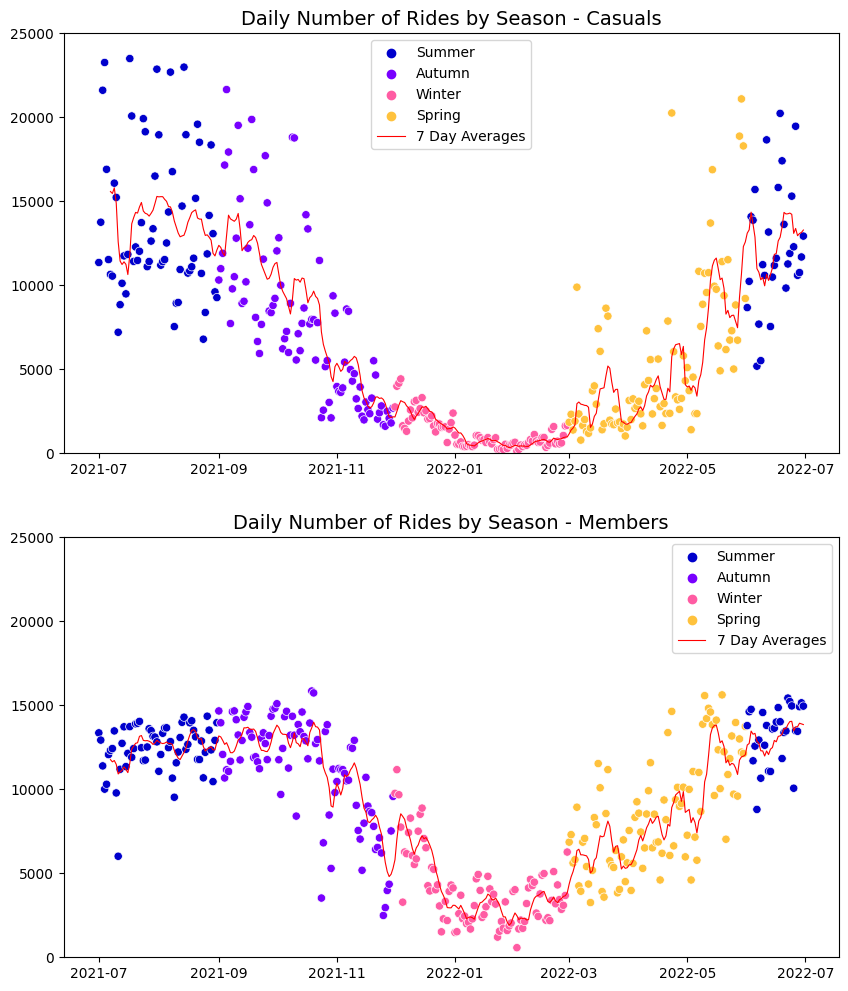

In [ ]:
# Group data daily and by membership type
daily_rides_count = timedf.groupby([pd.Grouper(key='started_at', freq='1D'),'is_member'])['numrides'].count().reset_index().copy()

# Rename 'numrides' to 'daily_num_rides'
daily_rides_count = daily_rides_count.rename(columns={'numrides':'daily_num_rides'})

# # function to define season
def identify_season(month):
    if month == 1 or month == 2 or month == 12:
        season = 'Winter'
    elif month == 3 or month == 4 or month == 5:
        season = 'Spring'
    elif month == 6 or month == 7 or month == 8:
        season = 'Summer'
    elif month == 9 or month == 10 or month == 11:
        season = 'Autumn'
    return season

# Add month column
daily_rides_count['month'] = daily_rides_count['started_at'].dt.month

# # Add column season: indicator numerically i.e. 1=Winter 2=Spring 3=Summer 4=Autumn
# daily_rides_count['season_numeric'] = daily_rides_count['started_at'].dt.month%12//3+1

# Add a new column season to daily_rides_count calling function
season_list = []
for month in daily_rides_count['month']:
    season_list.append(identify_season(month))
    
daily_rides_count['season'] = season_list

# #split df into casual and members
casual = daily_rides_count[daily_rides_count['is_member']==False].copy()
member =  daily_rides_count[daily_rides_count['is_member']==True].copy()

# #creating 7 day rolling averages
casual['7averages'] = casual['daily_num_rides'].rolling(7).mean()
member['7averages'] = member['daily_num_rides'].rolling(7).mean()

# plot scatter and lineplot for member and casual
fig, ax = plt.subplots(nrows=2,figsize=(10,12))
sns.scatterplot(data = casual, x="started_at", y="daily_num_rides", hue="season", palette='gnuplot2', ax=ax[0])
sns.lineplot(data = casual, x='started_at', y="7averages", color= 'red',ax=ax[0], linewidth = 0.8, label = '7 Day Averages')

sns.scatterplot(data = member, x="started_at", y="daily_num_rides", hue="season", palette='gnuplot2', ax=ax[1])
sns.lineplot(data = member, x="started_at", y="7averages", color= 'red',ax=ax[1], linewidth = 0.8, label = '7 Day Averages')

ax[0].set_title('Daily Number of Rides by Season - Casuals', fontsize=14)
ax[1].set_title('Daily Number of Rides by Season - Members', fontsize=14)

ax[0].set_xlabel('')
ax[0].set_ylabel('')

ax[1].set_xlabel('')
ax[1].set_ylabel('')

ax[0].set_ylim(0,25000)
ax[1].set_ylim(0,25000)

Linear regression:

Hypothesis: an increase in temperature will positively correlate with number of rides.


A graph to show ride count for member and casuals against mean temperature and month

In [ ]:
# chicago mean weather df joined to filtered data
df_month_temp = (
    big_frame
    .filter(['member_casual', 'month'])
    .merge(pd.DataFrame({'month': [1,2,3,4,5,6,7,8,9,10,11,12], 'chicago_mean_temp':[-3, -1, 4, 9, 15, 21, 24, 24, 20, 13, 6, -0]}), on='month',how ='left')
    .copy()
)
# df_month_temp.sample(4)


In [ ]:
# groupby on df_month_temp for facetgrid below 
num_rides_type_temp = (
    df_month_temp
    .groupby(['member_casual', 'month', 'chicago_mean_temp'])
    .size()
    .reset_index(name='num_rides')
    .copy()
)

Text(0.5, 0.98, 'Ride by Temperature')

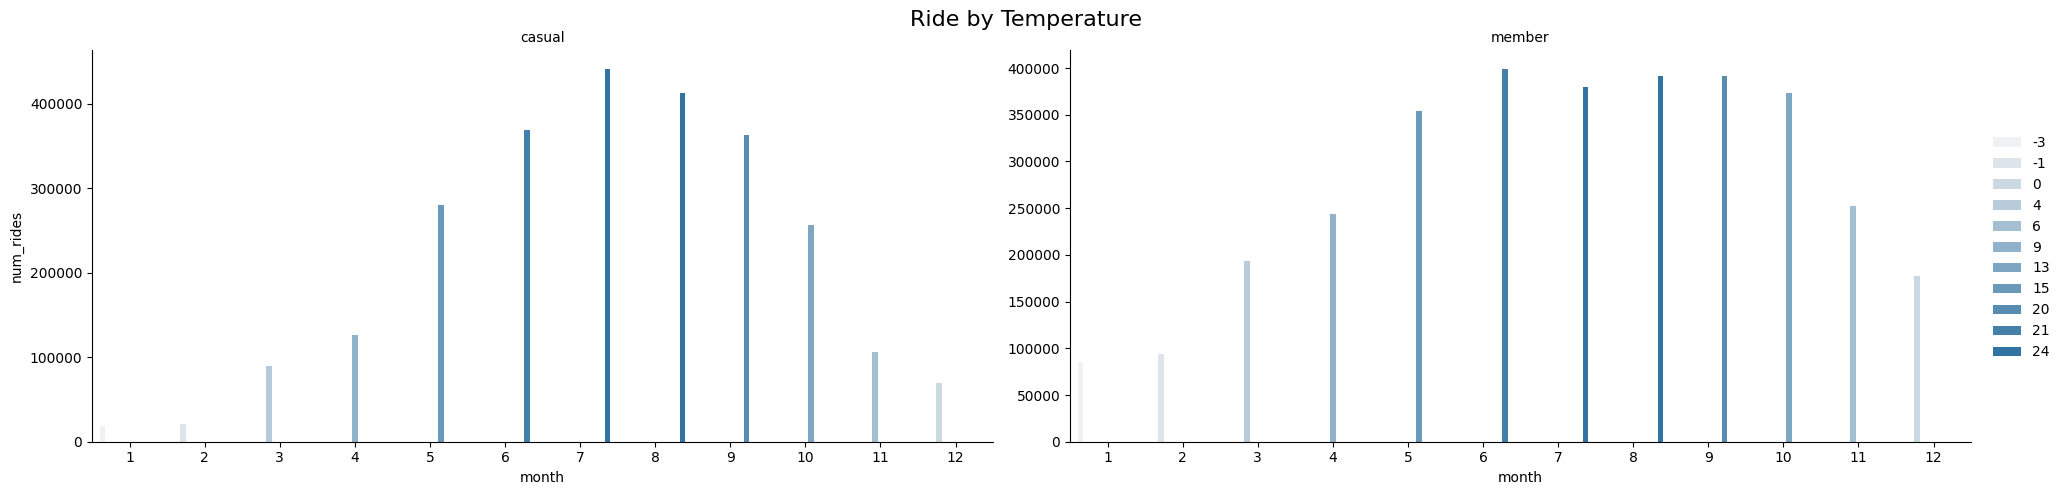

In [ ]:
# create facegrid using num_rides_type_temp df
fg = sns.FacetGrid(data=num_rides_type_temp, col='member_casual', col_wrap=2, aspect = 2, height = 5, sharex=False, sharey=False)
fg.map_dataframe(func=sns.barplot, x="month", y="num_rides", hue='chicago_mean_temp')
fg.add_legend()
fg.set_titles("{col_name}")
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('Ride by Temperature', fontsize=16)

The pairplot matrix below shows distribution of the data and patterns.  We can clearly see that in the warmer months ride count increases and drops in the colder months.

The assumption that ride count will increase linearly may not hold beyond this point if we were to continue to increase the x-value. For example an extreme heatwave may have the opposite effect. It is, however, a reasonable approximation for the range of values we have.

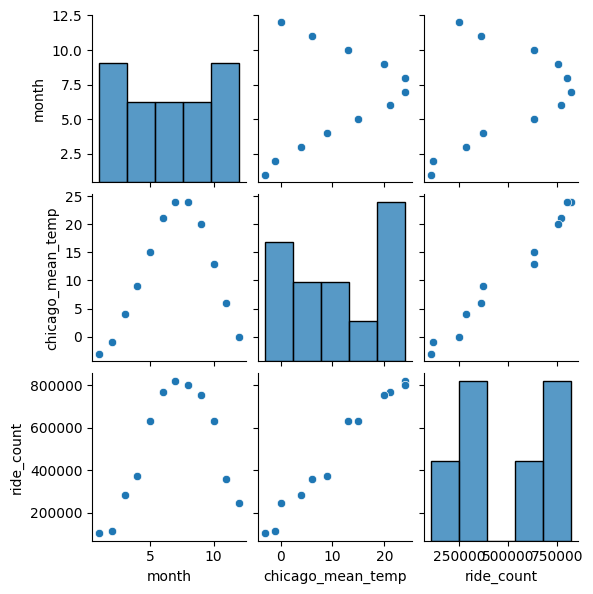

In [ ]:
# df pipe into pair plot
(
    df_month_temp
    .groupby(['month', 'chicago_mean_temp'])
    .size()
    .reset_index(name='ride_count')
    .pipe((sns.pairplot, 'data'), height=2)
)
# hue='', height=1

Visually from the plot below we can see the distribution of data points are roughly linear.

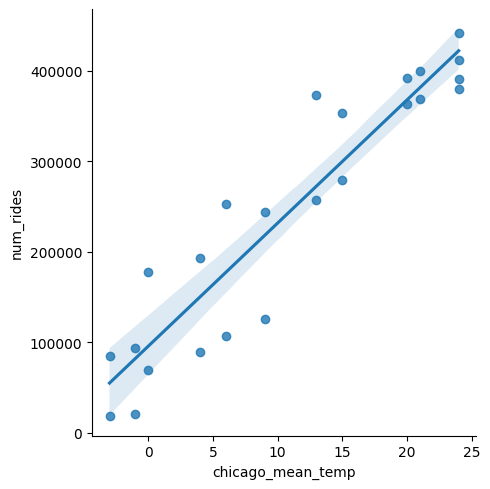

In [ ]:
# sns.scatterplot(data=num_rides_type_temp, x="chicago_mean_temp", y="ride_count")
sns.lmplot(data=num_rides_type_temp, x="chicago_mean_temp", y="num_rides")

Heatmap shows a strong association with mean temperature and ride count (corr=0.99).

<Axes: >

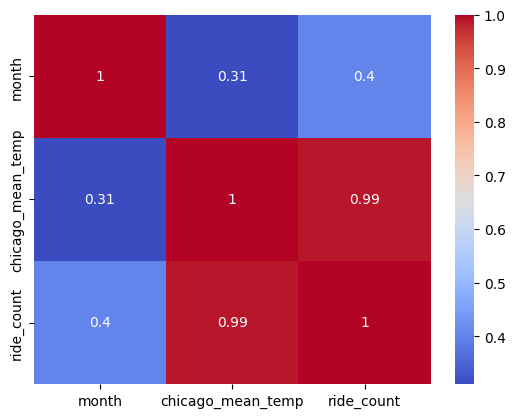

In [ ]:
# heatmap showing corr
(
    df_month_temp
    .groupby(['month', 'chicago_mean_temp'])
    .size()
    .reset_index(name='ride_count')
    .pipe(lambda _df: sns.heatmap(_df.corr(), cmap='coolwarm', annot=True))
)

From the regression and residual plots, we can observe that the points are randomly dispersed. The residuals (difference between observed and predicted values) scatter around the zero line, showing no discernible pattern, and are not one-sided. This indicates that there's no heteroscedasticity. Heteroscedasticity is a violation of one of the assumptions of regression that can undermine the validity of the model, but its absence in this case with the predictor variable 'chicago_mean_temp' strengthens the model's reliability.

From these results, it can be concluded that there is a statistically significant positive relationship between temperature and number of rides. This is validated by the p-value associated with the 'chicago_mean_temp' variable, which is less than 0.001.

We can utilize the following equation to anticipate the expected ride count for each unit increase in temperature:

expected ride_count = 4.06e+04 + 1.369e+05 * n

Examining the model summary:

P(>|t|): This is the p-value associated with the model coefficients. The p-value for temperature (0.000) is less than 0.05, reinforcing that there is a statistically significant association between temperature and number of rides.

R-squared: This value communicates the percentage of variation in the number of rides that can be attributed to the variation in temperature. In this case, 78.5% of the variation in the number of rides can be explained by temperature variation.

F-statistic & p-value: The F-statistic (32.94) and the associated p-value (0.000280) give insight into the overall significance of the regression model. It assesses whether the predictor variables in the model are useful for explaining the variation in the response variable. Given that the p-value is less than 0.05, our model is statistically significant, and temperature is considered to be a significant factor in explaining the variation in the number of rides.

As a result, we can reject the null hypothesis and conclude that temperature has a statistically significant influence on the number of rides.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/var/folders/sb/t51cmtfs4cl5kplzchw4rcsw0000gn/T/ipykernel_79944/2246304578.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(model.resid)


                            OLS Regression Results                            
Dep. Variable:             ride_count   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     32.94
Date:                Wed, 19 Jul 2023   Prob (F-statistic):           0.000280
Time:                        19:36:51   Log-Likelihood:                -149.38
No. Observations:                  11   AIC:                             302.8
Df Residuals:                       9   BIC:                             303.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.369e+05   9.43e+0

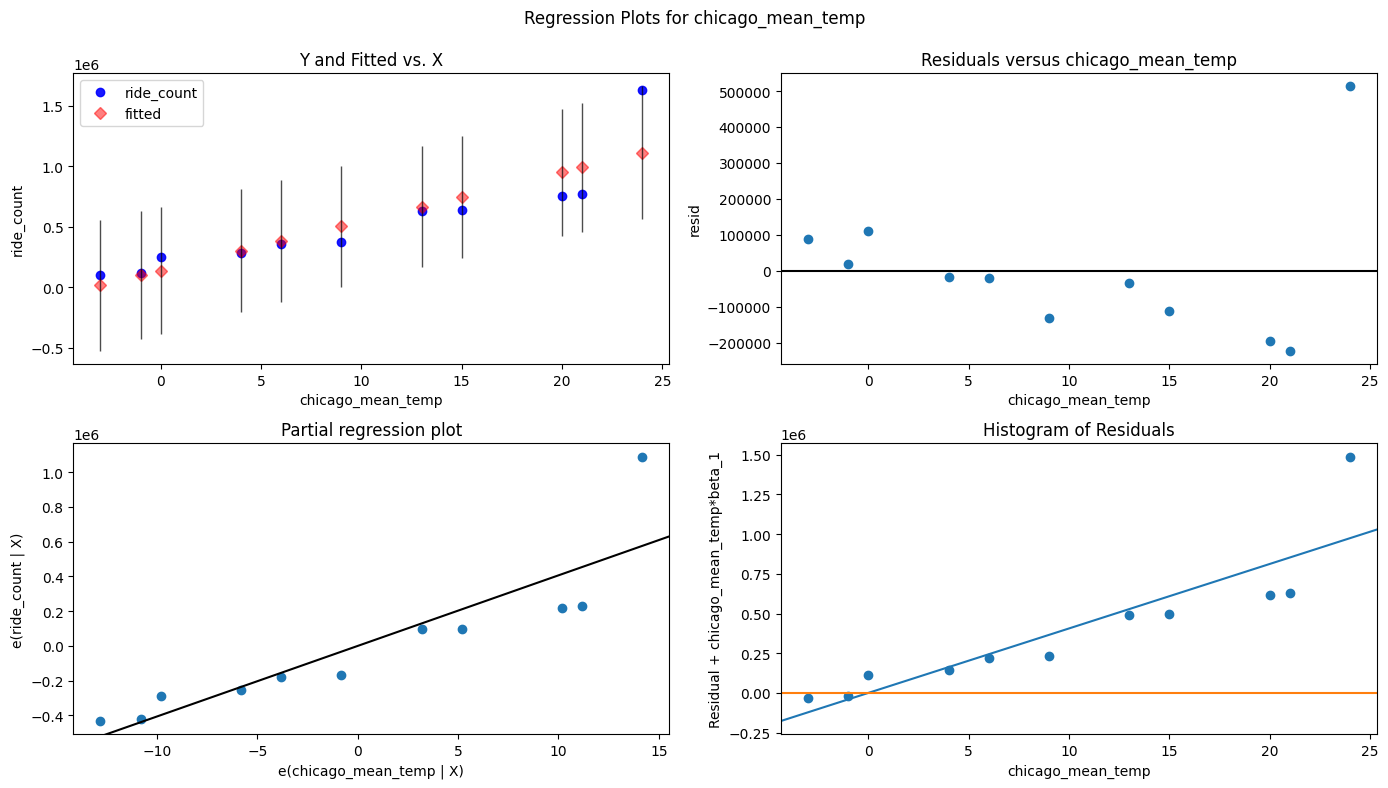

Shapiro-Wilk Test:
Statistic=0.843, p=0.034


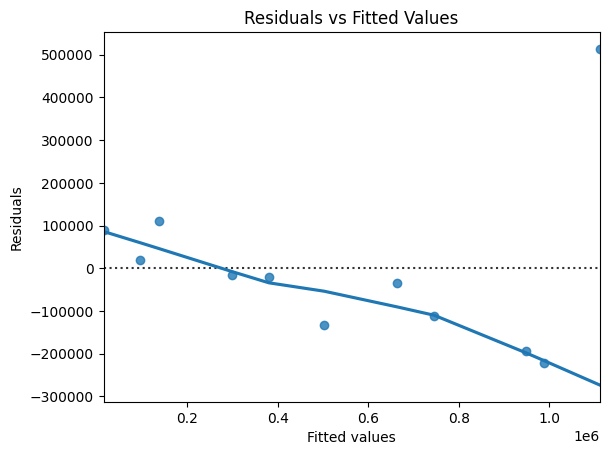

Confidence Intervals:
                              0              1
const             -76334.418844  350201.504500
chicago_mean_temp  24595.722843   56598.648062


In [ ]:


# df for ols 
OLS_df = (
    df_month_temp
    .groupby(['chicago_mean_temp'])
    .size()
    .reset_index(name='ride_count')
    .copy()
)

# Define predictor and response variables
y = OLS_df['ride_count']
x = OLS_df['chicago_mean_temp']

# Add constant to predictor variables
x = sm.add_constant(x)

# Fit linear regression model
model = sm.OLS(y, x).fit()

# Print model summary
print(model.summary())

# modify figure size
fig = plt.figure(figsize=(14, 8))
# creating regression plots
fig = sm.graphics.plot_regress_exog(model,
                                    'chicago_mean_temp',
                                    fig=fig)

# Checking Normality of residuals
sns.distplot(model.resid)
plt.title('Histogram of Residuals')
plt.show()

# Perform Shapiro-Wilk test goodness-of-fit test
print('Shapiro-Wilk Test:')
stat, p = stats.shapiro(model.resid)
print('Statistic=%.3f, p=%.3f' % (stat, p))

# Residuals vs Fitted values plot for checking linearity
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Confidence intervals
print('Confidence Intervals:')
print(model.conf_int())

In [ ]:
# # fit simple linear regression model
# linear_model = ols('ride_count ~ chicago_mean_temp', data= OLS_df).fit()
# # display model summary
# print(linear_model.summary())
  
# # modify figure size
# fig = plt.figure(figsize=(14, 8))
  
# # creating regression plots
# fig = sm.graphics.plot_regress_exog(linear_model,
#                                     'chicago_mean_temp',
#                                     fig=fig)

From looking at the plot below, it looks like the fitted regression line does a pretty good job of capturing the relationship between the increase temperature variable and the number of rides variable.

Text(0, 0.5, 'num ride')

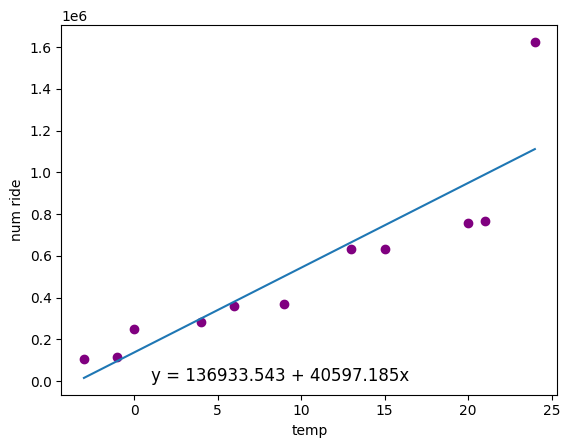

In [ ]:
#find line of best fit
a, b = np.polyfit(OLS_df['chicago_mean_temp'], OLS_df['ride_count'], 1)

#add points to plot
plt.scatter(OLS_df['chicago_mean_temp'], OLS_df['ride_count'], color='purple')

#add line of best fit to plot
plt.plot(OLS_df['chicago_mean_temp'], a*OLS_df['chicago_mean_temp']+b)

#add fitted regression equation to plot
plt.text(1, 90, 'y = ' + '{:.3f}'.format(b) + ' + {:.3f}'.format(a) + 'x', size=12)

#add axis labels
plt.xlabel('temp')
plt.ylabel('num ride')

Simple linear regression model using sklearn to predict daily ride count based on temperature

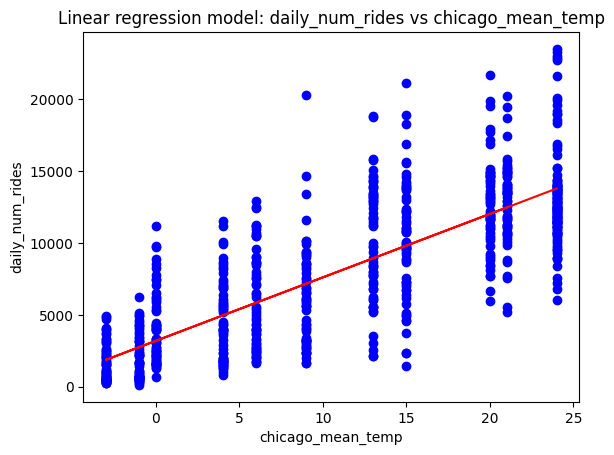

Predicted daily ride count if temperature is 6: 5834.0
Coefficients: 
 [[441.34981389]]
Intercept: 
 [3185.67288139]


In [ ]:

df_daily_ride_temp = (
    daily_rides_count
    .filter(['is_member', 'month', 'daily_num_rides'])
    .merge(pd.DataFrame({'month': [1,2,3,4,5,6,7,8,9,10,11,12], 'chicago_mean_temp':[-3, -1, 4, 9, 15, 21, 24, 24, 20, 13, 6, -0]}), on='month', how ='left')
)

x = df_daily_ride_temp.loc[:,'chicago_mean_temp'].values.reshape(-1,1)
y = df_daily_ride_temp.loc[:,'daily_num_rides'].values.reshape(-1,1)

temp_ride_model = LinearRegression()
temp_ride_model.fit(x,y)

# unknown value
unk_x = [[6]]

# Here, we predict without appending unk_x to x
y_pred = temp_ride_model.predict(x)

plt.scatter(x,y,color = 'b')
plt.plot(x,y_pred,color = 'r')
plt.title("Linear regression model: daily_num_rides vs chicago_mean_temp")
plt.xlabel('chicago_mean_temp')
plt.ylabel('daily_num_rides')
plt.show()

# Now, we predict unk_x separately
print(f"Predicted daily ride count if temperature is {(unk_x)[0][0]}: {temp_ride_model.predict(unk_x)[0][0].round(0)}")
# The coefficients
print('Coefficients: \n', temp_ride_model.coef_)
print('Intercept: \n', temp_ride_model.intercept_)


## SUMMARY ANALYSIS

There is 10% more member rides then casual rides. (From the data we are unable to tell how many rides are from the same rider.)

Mean casual ride length is 30 mins and member is 13 mins. Therefore, on average ride length for casual ride is 17 mins longer than member rides. There were more rides during the week for members and higher frequency of rides in the weekend for casual rides. Casual rides were longer than members on all days and casual rides were longest at the weekends. Whereas, member ride length was slightly longer on weekends, but other all had similar ride lengths throughout the week.

During the week ride count peaked early afternoon for casual riders. For members, ride count had two peaks, one in the morning at 8am and early evening around 6pm. On the weekend, although more casual riders, both casual and members had similar patterns in ride times with a peak early afternoon.

The data also shows that ride count was greater in the warmer months and this increase in ride count was bigger for casual riders. There were more member riders compared to casual riders riding in the colder months.

We observe that members ride faster than casual riders. If the data had personal details, casual riders that ride fast would be a good candidate for targeted marketing.

## MAP

First I will do some checks and cleaning on the geospatial points to try to standardise across the data set which will help in rendering the map. Steps are as follows:

Standard deviation is less than 1, indicating data points are close to the mean. We know from this that there are no major outliers.

In [ ]:
# checking sd dynamically across lat/lng columns, dropping NaN.
col_names = ['start_lat', 'start_lng',  'end_lat', 'end_lng']

for col in col_names:
    sd = big_frame[col].std(skipna=True, axis=0).round(2)
    if sd < 1 or sd > -0.5:
        print(f'{col} data points are close to the mean, sd = {sd}')
    else:
        print(f'There is high variation in the {col} data, sd = {sd}')

start_lat data points are close to the mean, sd = 0.05
start_lng data points are close to the mean, sd = 0.03
end_lat data points are close to the mean, sd = 0.05
end_lng data points are close to the mean, sd = 0.03


Because there are no major outliers I have created a unique lat/lng for each station name using mean lat/lng

In [ ]:
# create unique look-up table, drop NaN 
lat_lng_unique_df = (
    big_frame
    .filter(['start_station_name', 'start_lat', 'start_lng'])
    .groupby('start_station_name', dropna=True)
    .mean()
    .rename(columns={'start_lat': 'mean_start_lat', 'start_lng':'mean_start_lng'})
    .copy()
)

#merge look-up table to filtered big_frame to replace lat/lng with mean lat/lng for start_station_name 
lat_lng_unique_df = (
    big_frame
    .filter(['start_station_name', 'member_casual'])
    .merge(lat_lng_unique_df, on=['start_station_name'], how ='inner')
)
# lat_lng_unique_df.insert(5,'numrides',1)

Map to show ride count by location and membership type.

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Create a base map centered around the given coordinates
m = folium.Map(location=[41.8781, -87.6298], zoom_start=9.5, min_zoom=9.5)

# Define bounds
bounds = [[41.57387003253022, -87.50844297095841], [42.18696858189114, -88.10198621847373]]
m.fit_bounds(bounds)

# Filter data for member and casual
members_data = lat_lng_unique_df[lat_lng_unique_df['member_casual'] == 'member']
casual_data = lat_lng_unique_df[lat_lng_unique_df['member_casual'] == 'casual']

# Create marker clusters for members
member_cluster = MarkerCluster(name='member').add_to(m)
for _, row in members_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=str(row['start_station_name'])
    ).add_to(member_cluster)

# Create marker clusters for casual
casual_cluster = MarkerCluster(name='casual').add_to(m)
for _, row in casual_data.iterrows():
    folium.Marker(
        location=[row['lat'], row['lng']],
        popup=str(row['start_station_name'])
    ).add_to(casual_cluster)

# Add layer controls to the map
folium.LayerControl().add_to(m)

# Display the map
m


In [ ]:
# # import folium
# import folium
# from folium import plugins 

# # # marker data for casual riders layer
# casual_markers = (
#     lat_lng_unique_df
#     .query('member_casual == "casual"')
#     .filter(['mean_start_lat', 'mean_start_lng'])
# )

# # marker data for members layer
# member_markers = (
#     lat_lng_unique_df
#     .query('member_casual == "member"')
#     .filter(['mean_start_lat', 'mean_start_lng'])
# )

# # Create a folium map, add two layers (member/casual), add layer control to swap between them
# m = folium.Map(location=[lat_lng_unique_df['mean_start_lat'].mean(), lat_lng_unique_df['mean_start_lng'].mean()])
# plugins.FastMarkerCluster(data=casual_markers, overlay=True, name='casual').add_to(m)
# plugins.FastMarkerCluster(data=member_markers, overlay=True, name='member').add_to(m)
# folium.LayerControl(collapsed=False).add_to(m)
# runs but very slow, can crash if run out of memory 
# left in as when it does render its useful, better in sep document.
# m

## ACT

top recommendations based on my analysis:

Direct advertising at stations where there are higher frequency of casual riders (see map).

Focus special offers and marketing for annual membership over the warmer months when there are more causal riders to reach.

Offer an off peak annual membership that fits the profile of a casual rider (i.e. better deal for weekends and afternoons). Make annual membership seem more cost effective by increasing the price of day passes at weekends and peak times for casual riders. Casual riders on average ride for longer so make membership more flexible i.e. limited length of time for casual riders vs membership.

Another recommendation, however a compromise on the objective might include monthly membership or rolling contract membership to entice casuals to membership, who are put off committing to an annual membership.

Data Limitations and additional data that could expand scope of analysis:


Missing Demographics: 

The unique ride IDs meant that I couldn’t determine how often one rider used the service. It would be interesting to know how often users used the services. It could be that casual riders use services 4-8 times a month and so a membership type could be aimed at this type of ride use. Knowing demographics of ride users would help to direct marketing and profile casual and member type.

Data Collection Period: 

COVID-19 is very much a persistent problem in 2021. Commuting habits may different to 'business-as-usual' pre-covid.

## THIS REPORT WAS WRITTEN BY: ASHLEY CUZZOCREA 

In [ ]:
big_frame.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'file', 'month', 'day', 'year', 'day_of_week',
       'start_hour', 'ride_length', 'ride_km', 'rider_speed'],
      dtype='object')

In [ ]:
# Specify the folder path and write DataFrame to a CSV file

file_path = '/Users/ashleycuzzocrea/Documents/udemy/Data Science Bootcamp/T36_capstone_clylistic/output.csv'
big_frame.to_csv(file_path, index=False)

